In [54]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.optimize import minimize

import emcee
import corner

In [55]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

(0.0, 1.0)

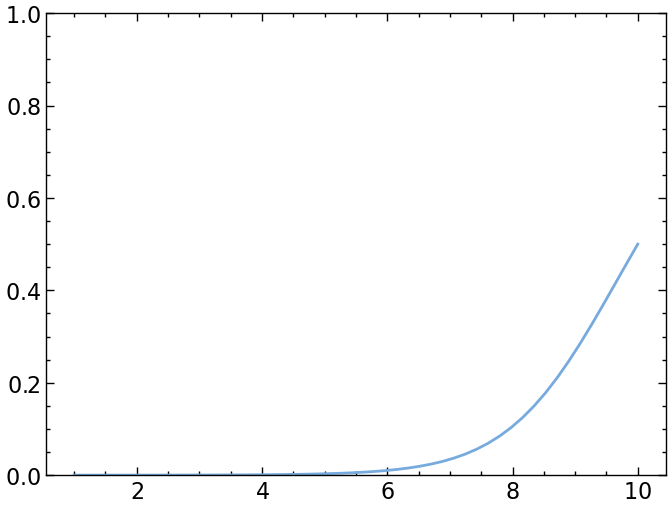

In [56]:
x = np.linspace(1, 10)
l0 = 10
alpha = 0
beta = 0.5
a = 0.5
xi = 0.23
L = 10**(x)
L0 = 10**l0
f1 = 1 - (1 + 3*(L/L0)**(1 - 2*xi))**-a
plt.plot(x, f1)
plt.ylim(0, 1)

In [110]:
26 + alpha + beta*x

array([25.87142144, 26.00992956, 26.02219736, ..., 26.23754131,
       25.43252037, 26.20150932])

In [158]:
def f_X(x, x0, alpha, beta, f_a=1, l0=30, xi=0.23, a=0.52, delta=1, theta2=2.5):
    #a = 0.53
    #xi = 0.23
    # Type 1 function (Oh 2015; https://ui.adsabs.harvard.edu/abs/2015ApJS..219....1O/abstract)
    # stellar mass to luminosity
    L =  10**(26 + alpha + beta*x)
    L0 = 10**(l0 + 26)
    f1 = 1 - (1 + 3*(L/L0)**(1 - 2*xi))**-a

    # Occupation function
    focc =  1/(1 + delta * np.exp(-theta2*(x - x0)))**(1/delta)
    
    return f_a * f1 * focc

In [59]:
def log_likelihood(theta, x, y, xerr, yerr, xp):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f, f_a, l0, xi, a, log_delta, theta2 = theta
    delta = np.exp(log_delta)
    
    # Residuals
    s2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    s_ul2 = np.exp(2*log_f)**2 + (beta*xerr)**2

    # p(y|x)
    f = st.norm.pdf((y - alpha - beta*x), scale=np.sqrt(s2))
    
    # Likelihood
    mask_det = (yerr > 0)
    S = st.norm.sf(-(y - alpha - beta*x), scale=np.sqrt(s_ul2))

    f_occ_det = f_X(x[mask_det]+xp, log_ms0+xp, alpha, beta, f_a, l0, xi, a, delta, theta2)
    f_occ_cens = f_X(x[~mask_det]+xp, log_ms0+xp, alpha, beta, f_a, l0, xi, a, delta, theta2)
        
    # Probability distributions
    p_det = f_occ_det * f[mask_det]
    p_cens = f_occ_cens * S[~mask_det] + 1 - f_occ_cens

    # Clip
    p_det = np.clip(p_det, 1e-12, 1)
    p_cens = np.clip(p_cens, 1e-12, 1)
    
    # Likelihood
    ll_det = np.log(p_det)
    ll_cens = np.log(p_cens)

    ll = np.sum(ll_det) + np.sum(ll_cens)
    
    return ll

def log_likelihood_init(theta, x, y, xerr, yerr):
    
    # parameters to be fit
    alpha, beta, log_f = theta

    #if beta < 0:
    #    return -np.inf

    sigma2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    z = (y - alpha - beta*x)/np.sqrt(sigma2)
    
    mask_det = (yerr > 0)
    
    f = 1/np.sqrt(sigma2*2*np.pi)*np.exp(-z**2/2)
    
    ll = np.sum(np.log(f[mask_det]))
    
    return ll

In [166]:
def log_prior(theta):
    logms0, alpha, beta, log_f, f_a, l0, xi, a, log_delta, theta2 = theta
    # Priors
    if -5.0 < logms0 < 5.0 and -5.0 < alpha < 5.0 and 0.0 < beta < 5.0 and -2.0 < log_f < 1.0 and 0 < f_a < 1 and -0.45 < xi < 0.45 and -5 < l0 < 40 and 0.05 < a < .95 and -2 < log_delta < 6 and 0 < theta2 < 6:
      #return 0.0
      return np.log(st.norm.pdf(a, 0.52, 0.05)) + np.log(st.norm.pdf(xi, 0.23, 0.02))
    return -np.inf

def log_probability(theta, x, y, xerr, yerr, p_obs, xp):
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr, p_obs, xp)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

## Simulation

In [61]:
# set up our data
N = 400  # number of data points
sigmatrue = 0.08  # standard deviation of noise
x = np.linspace(7.0, 12.0, N) # log Ms
flag_lim = np.zeros_like(x) # upper limit flag

_xerr = 0.3
_yerr = 0.1

mtrue = 0.8  # true gradient
ctrue = 31  # true y-intercept
#ctrue = 47
logms0true = 6.5 # occupation fraction pivot mass
low = 38.0 # detection limit

# make data
p_occ = 0.5*(1 + np.tanh(2.5**np.abs(8.9 - logms0true) * (x - logms0true)))
# Generate data
I_occ = np.random.binomial(1, p_occ)

y = I_occ*st.norm.rvs(ctrue + mtrue*x, np.sqrt(_yerr**2 + sigmatrue**2), size=len(x))
x = st.norm.rvs(x, _xerr, size=len(x))

# detection limits
mask = y < low
flag_lim[mask] = 1
y = np.clip(y, low, None)

# Random
#y[::2] = 40 # every Nth point set to low
#flag_lim[::2] = 1

xerr = np.full_like(y, _xerr)
yerr = np.full_like(y, -1.0)
yerr[flag_lim==0] = _yerr
#yerr = np.full_like(y, _yerr)

sigma_var = np.full_like(y, 60)
sigma_var[flag_lim==1] = 0

In [62]:
#_,_ = inference(x, y, xerr, yerr, sigma_var, nburn=500, nsamp=2000)

# AMUSE X-ray

In [63]:
import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)

cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_20021/331117030.py:56: RuntimeWarning: invalid value encountered in divide
  completeness_BGG = hist/hist_model


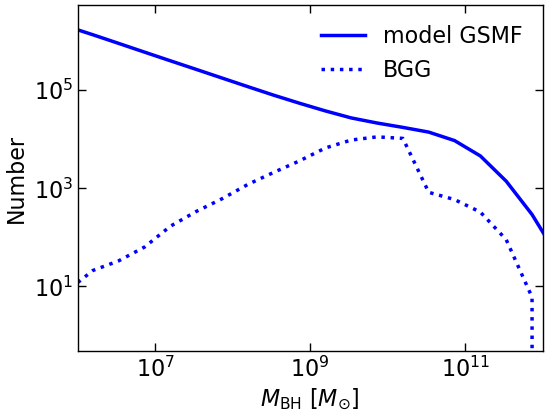

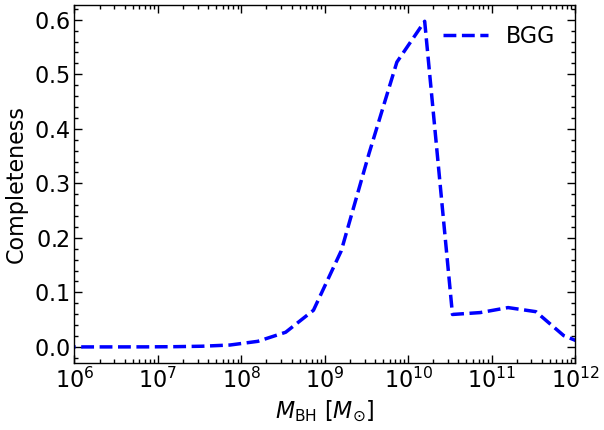

In [64]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 13, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))

# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
# Add some scatter
M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

hist_model, bin_edges = np.histogram(M_star, bins=_M)
ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)

cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

stellar_mass = data_bgg['Mstar']
hist, bin_edges = np.histogram(stellar_mass, bins=_M)

ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

hist_model, bin_edges = np.histogram(M_star, bins=_M)
completeness_BGG = hist/hist_model
completeness_BGG[~np.isfinite(completeness_BGG)] = 0
ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax0.set_xlim(1e6, 1e12)

ax0.set_xlabel(r'$M_{\rm{BH}}$ [$M_{\odot}$]')
ax0.set_ylabel(r'Number')
ax0.legend(fontsize=16)

#####


ax1.set_xlim(1e6, 1e12)

ax1.set_xlabel(r'$M_{\rm{BH}}$ [$M_{\odot}$]')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)


fig.tight_layout()
fig.savefig('completeness.pdf', dpi=300)

# Updated redshifts

In [65]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 400 # seconds

result_table = Vizier(columns=['RA_ICRS', 'DE_ICRS', 'zsp'], catalog="V/154/sdss16",
                      timeout=6400).query_region(cat_bgg, radius=2.5*u.arcsec, column_filters={'DE_ICRS': '>-30'})
print('done')

mask_zsp = np.isfinite(result_table[0]['zsp'].data.data)
cat_result = SkyCoord(result_table[0]['RA_ICRS'][mask_zsp], result_table[0]['DE_ICRS'][mask_zsp])
idx_result, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_result, 2.5*u.arcsec)

data_bgg['z_dr16'] = -1.0 # mJy
data_bgg['z_dr16'][idx_bgg] = result_table[0]['zsp'].data.data[mask_zsp][idx_result]

done


In [66]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 400 # seconds

result_table = Vizier(columns=['RAJ2000', 'DEJ2000', 'z', 'Prob'], catalog="J/MNRAS/474/3875/gamadr3",
                      timeout=6400).query_region(cat_bgg, radius=2.5*u.arcsec, column_filters={'DE_ICRS': '>-30'})
print('done')

mask_zsp = np.isfinite(result_table[0]['z'].data.data) & (result_table[0]['Prob'] > 0.0)
cat_result = SkyCoord(result_table[0]['RAJ2000'][mask_zsp], result_table[0]['DEJ2000'][mask_zsp])
idx_result, idx_bgg, d2d, d3d = cat_bgg.search_around_sky(cat_result, 2.5*u.arcsec)

data_bgg['z_gama'] = -1.0 # mJy
data_bgg['z_gama'][idx_bgg] = result_table[0]['z'].data.data[mask_zsp][idx_result]

done


In [67]:
#data_bgg.write('bgg_dr16.dat', overwrite=True)

## Load 

In [68]:
data_bgg = Table.read('bgg_dr16.dat', format='ascii') 

data_bgg['z_best'] = -1.0
data_bgg['z_best'] = data_bgg['z_dr16']
mask = data_bgg['z_best'] == -1 
data_bgg['z_best'][mask] = data_bgg['z_gama'][mask]
mask = data_bgg['z_best'] == -1 
data_bgg['z_best'][mask] = data_bgg['z'][mask]
data_bgg

ObjID,RA,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z,nsaid,z_dr16,Mstar_mendel,NSAID,z_gama,z_best
str9,float64,float64,str1,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,float64,float64
NSA32338,165.2568666,49.9687436,r,123,1876.02589,17.7498718,0.00863076472,0.0,1.378457,0.0,13473236114.2857,1,0.0459751263260841,32338,0.04598,10.128000259399414,32338,-1.0,0.04598
NSA4610,263.7552145,57.05243448,r,261,1552.00244,17.2713766,0.01471833946,0.404314,1.561055,0.00824,636912065.306122,1,0.0472323037683963,4610,0.04723,8.696000099182129,4610,-1.0,0.04723
NSA30953,190.0169633,5.484321547,r,186,1774.15069,18.20166066,0.03128655963,3.581902,1.176183,1.69715,4655425828.57142,2,0.0473862141370773,30953,0.04739,-1.0,30953,-1.0,0.04739
NSA6367,17.18550947,0.9418872917,r,75,1212.94767,18.78117209,0.02746706314,0.466396,1.113544,0.064007,329882481.632653,1,0.0404198467731475,6367,0.04042,-1.0,6367,-1.0,0.04042
NSA12399,149.3889539,1.701860673,r,184,1182.86855,17.64952745,0.01243696148,0.0,1.014212,0.0,3649560816.32653,0,0.0323247872292995,12399,0.03232,9.616999626159668,12399,-1.0,0.03232
NSA4257,260.6403652,63.76327669,r,233,1117.10276,18.76771078,0.03325125329,0.151865,1.320365,0.053861,713694236.734694,1,0.0272146537899971,4257,0.02721,-1.0,4257,-1.0,0.02721
NSA13277,149.6394076,3.055199532,r,222,1182.87,18.33354635,0.01228406147,0.0,0.517527,0.0,6173718987.7551,0,0.0420763529837131,13277,-1.0,-1.0,13277,-1.0,0.0420763529837131
NSA5317,345.4543177,0.5920527603,r,83,1166.91038,16.62091611,0.06837968054,93.506096,0.007598,16.265416,31183642122.4489,2,0.042013332247734,5317,0.04201,10.600000381469727,5317,-1.0,0.04201
NSA9486,118.1837049,44.55671821,r,28,861.7469,19.21490745,0.0806795953,6.637044,0.690311,3.402406,9667024979.59183,1,0.0457814708352088,9486,0.04578,9.777000427246094,9486,-1.0,0.04578


In [69]:
dat_nsa = Table.read('nsa_v0_1_2.fits')
cat_nsa = SkyCoord(dat_nsa['RA'], dat_nsa['DEC'], unit=u.deg)

# Read NSA
data_bgg['NSAID'] = np.array([int(s[3:]) for s in data_bgg['ObjID']])
dat_nsa = table.join(data_bgg, dat_nsa, keys='NSAID')
dat_nsa = dat_nsa[dat_nsa['z_best']>0]
print(len(dat_nsa))
dat_nsa = table.unique(dat_nsa, keys='NSAID')
print(len(dat_nsa))


47014
47009


## New Stellar Masses

In [70]:
filt_use = ['GALEX_FUV','GALEX_NUV','sdss.up','sdss.gp', 'sdss.rp', 'sdss.ip', 'sdss.zp']

data_phot = []
fluxes = []
fluxes_err = []

# Add ID

data_phot.append(dat_nsa['NSAID'])

# Add redshifts
data_phot.append(dat_nsa['z_best']) # Use photo-z first

for i, b in enumerate(filt_use):
        fluxes.append(dat_nsa['PETROFLUX'].data.data[:,i]*0.003631) # mJy
        data_phot.append(dat_nsa['PETROFLUX'].data.data[:,i]*0.003631) # mJy

for i, b in enumerate(filt_use):
        fluxes_err.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy
        data_phot.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy

data_phot = np.array(data_phot)
fluxes = np.array(fluxes)
fluxes_err = np.array(fluxes_err)

fmt = '%d ' + ' '.join(['%0.8f']*(len(filt_use)*2 + 1))

print(data_phot.shape)

# Replace invalid values
data_phot[data_phot<=0,] = -9999
data_phot[~np.isfinite(data_phot),] = -9999

# Redshifts

print(data_phot.shape)
print(len(fmt.split()))

hdr = 'id redshift galex.FUV galex.NUV sdss.up sdss.gp sdss.rp sdss.ip sdss.zp galex.FUV_err galex.NUV_err sdss.up_err sdss.gp_err sdss.rp_err sdss.ip_err sdss.zp_err'

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt('cigale/bgg/phot.dat', data_phot.T, header=hdr, fmt=fmt)

(16, 47009)
(16, 47009)
16
hdr: 1


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_20021/764826703.py:19: RuntimeWarning: divide by zero encountered in divide
  fluxes_err.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_20021/764826703.py:20: RuntimeWarning: divide by zero encountered in divide
  data_phot.append((1/dat_nsa['PETROFLUX_IVAR'].data[:,i]*0.003631)**2) # mJy


### pcigale run

0.0 Mbyte


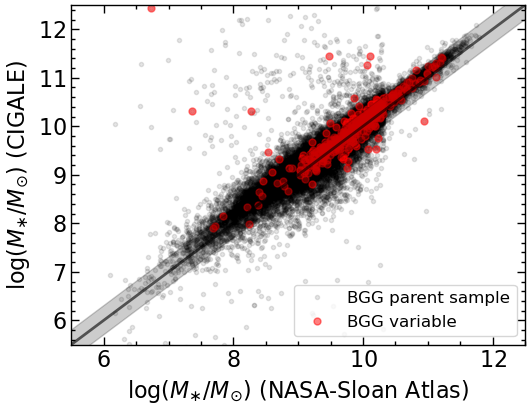

In [71]:
from matplotlib import cm, ticker

mask_det = (dat_nsa['SigQSO'] > 2) & (dat_nsa['SigVary'] > 2) & (dat_nsa['SigQSO'] >= dat_nsa['SigNotQSO'])


results_rv15 = fits.open('cigale/bgg/float/out/results.fits')[1].data

fig, ax = plt.subplots(1,1, figsize=(5.5, 4.3))

dM_rv15 = 0.434*results_rv15['bayes.stellar.m_star_err']/results_rv15['bayes.stellar.m_star']
dMtot_rv15 = np.sqrt(dM_rv15**2 + (0.2)**2)

mask_chi = results_rv15['best.reduced_chi_square'] < 5
x = np.log10(dat_nsa['Mstar'][mask_chi])
y = np.log10(results_rv15['bayes.stellar.m_star'][mask_chi])

mask_dM = np.abs(y - x) < 1
x = x[mask_dM]
y = y[mask_dM]
# Peform the kernel density estimate
xmin, xmax = 5, 13
ymin, ymax = 5, 13
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

#cfset = ax.contourf(xx, yy, f, cmap='Greys', levels=3, zorder=-1)
#cset = ax.contour(xx, yy, f, colors='k')

ax.errorbar(np.log10(dat_nsa['Mstar'][mask_chi]), np.log10(results_rv15['bayes.stellar.m_star'][mask_chi]), markersize=3,
            lw=0.5, linestyle='none', marker='o', color='k', zorder=-1, alpha=0.1, label='BGG parent sample')

ax.errorbar(np.log10(dat_nsa['Mstar'][mask_chi & mask_det]), np.log10(results_rv15['bayes.stellar.m_star'][mask_chi & mask_det]), markersize=5,
            lw=0.5, linestyle='none', marker='o', color='r', zorder=1, alpha=0.5, label='BGG variable')


x = np.linspace(5, 13)
ax.plot(x, x, color='k', zorder=10, alpha=0.6)
ax.fill_between(x, x + 0.3, x - 0.3, alpha=0.2, color='k', zorder=10)

ax.set_xlim(5.5, 12.5)
ax.set_ylim(5.5, 12.5)

ax.set_xlabel(r'$\log (M_{\ast} / M_{\odot})$ (NASA-Sloan Atlas)')
ax.set_ylabel(r'$\log (M_{\ast} / M_{\odot})$ (CIGALE)')

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()

import io
with io.BytesIO() as buffer:
    filesize = (buffer.getbuffer().nbytes * u.byte).to(u.megabyte)
    print(filesize)
    fig.savefig('bgg_mass.pdf', dpi=300)

# stellar massses from RV15 with AGN contribution removed
# generally, these nearby galaxies are host dominated, but tells us that 
# our stellar masses are reasonable for the more host domianted sources

In [72]:
data_bgg

ObjID,RA,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z,nsaid,z_dr16,Mstar_mendel,NSAID,z_gama,z_best
str9,float64,float64,str1,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,float64,float64
NSA32338,165.2568666,49.9687436,r,123,1876.02589,17.7498718,0.00863076472,0.0,1.378457,0.0,13473236114.2857,1,0.0459751263260841,32338,0.04598,10.128000259399414,32338,-1.0,0.04598
NSA4610,263.7552145,57.05243448,r,261,1552.00244,17.2713766,0.01471833946,0.404314,1.561055,0.00824,636912065.306122,1,0.0472323037683963,4610,0.04723,8.696000099182129,4610,-1.0,0.04723
NSA30953,190.0169633,5.484321547,r,186,1774.15069,18.20166066,0.03128655963,3.581902,1.176183,1.69715,4655425828.57142,2,0.0473862141370773,30953,0.04739,-1.0,30953,-1.0,0.04739
NSA6367,17.18550947,0.9418872917,r,75,1212.94767,18.78117209,0.02746706314,0.466396,1.113544,0.064007,329882481.632653,1,0.0404198467731475,6367,0.04042,-1.0,6367,-1.0,0.04042
NSA12399,149.3889539,1.701860673,r,184,1182.86855,17.64952745,0.01243696148,0.0,1.014212,0.0,3649560816.32653,0,0.0323247872292995,12399,0.03232,9.616999626159668,12399,-1.0,0.03232
NSA4257,260.6403652,63.76327669,r,233,1117.10276,18.76771078,0.03325125329,0.151865,1.320365,0.053861,713694236.734694,1,0.0272146537899971,4257,0.02721,-1.0,4257,-1.0,0.02721
NSA13277,149.6394076,3.055199532,r,222,1182.87,18.33354635,0.01228406147,0.0,0.517527,0.0,6173718987.7551,0,0.0420763529837131,13277,-1.0,-1.0,13277,-1.0,0.0420763529837131
NSA5317,345.4543177,0.5920527603,r,83,1166.91038,16.62091611,0.06837968054,93.506096,0.007598,16.265416,31183642122.4489,2,0.042013332247734,5317,0.04201,10.600000381469727,5317,-1.0,0.04201
NSA9486,118.1837049,44.55671821,r,28,861.7469,19.21490745,0.0806795953,6.637044,0.690311,3.402406,9667024979.59183,1,0.0457814708352088,9486,0.04578,9.777000427246094,9486,-1.0,0.04578


In [73]:

dat_nsa['log_mstar_cigale'] = -1.0
dat_nsa['log_mstar_err_cigale'] = -1.0
# Match on ID?
dat_nsa['log_mstar_cigale'][mask_chi] = np.log10(results_rv15['bayes.stellar.m_star'][mask_chi])
dat_nsa['log_mstar_err_cigale'][mask_chi] = dMtot_rv15[mask_chi]

#data_bgg['log_mstar_err_cigale'][mask_chi] = dMtot_rv15[mask_chi]

### GMF

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_20021/245347645.py:57: RuntimeWarning: invalid value encountered in divide
  completeness_BGG = hist/hist_model


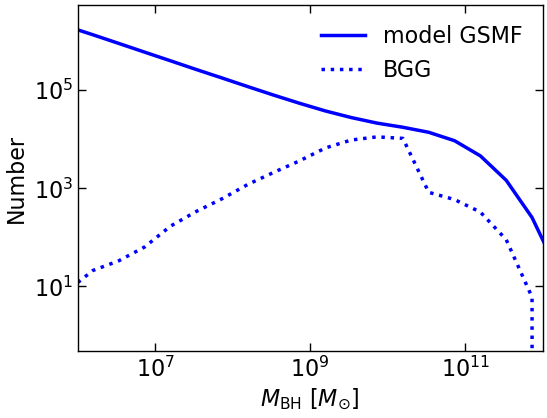

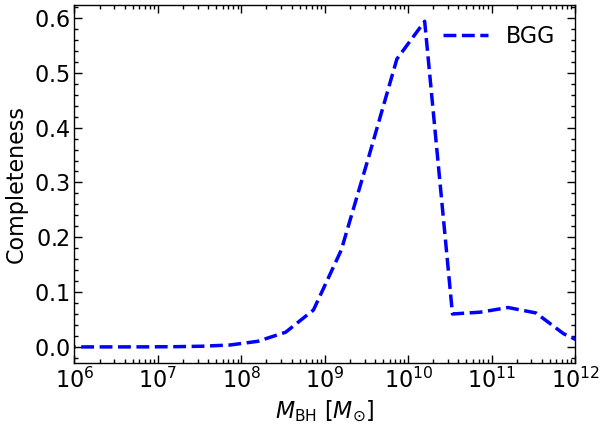

In [74]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 13, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5))


# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
# Add some scatter
M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

hist_model, bin_edges = np.histogram(M_star, bins=_M)
ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

import pandas as pd
_data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
_data_bgg = Table.from_pandas(_data_bgg)
_data_bgg['nsaid'] = np.array([s[3:] for s in _data_bgg['ObjID']], dtype=int)

_cat_bgg = SkyCoord(_data_bgg['RA'], _data_bgg['Dec'], unit=u.deg)

stellar_mass = _data_bgg['Mstar']
hist, bin_edges = np.histogram(stellar_mass, bins=_M)

ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

hist_model, bin_edges = np.histogram(M_star, bins=_M)
completeness_BGG = hist/hist_model
completeness_BGG[~np.isfinite(completeness_BGG)] = 0
ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax0.set_xlim(1e6, 1e12)

ax0.set_xlabel(r'$M_{\rm{BH}}$ [$M_{\odot}$]')
ax0.set_ylabel(r'Number')
ax0.legend(fontsize=16)

#####


ax1.set_xlim(1e6, 1e12)

ax1.set_xlabel(r'$M_{\rm{BH}}$ [$M_{\odot}$]')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)


fig.tight_layout()
fig.savefig('completeness.pdf', dpi=300)

detections: 389
Maximum likelihood estimates:
alpha = 26.397
beta = 0.454
sigma = 0.202


  4%|▍         | 447/10000 [00:54<18:42,  8.51it/s]/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_20021/3523892452.py:11: RuntimeWarning: overflow encountered in power
  focc =  1/(1 + delta * np.exp(-theta2*(x - x0)))**(1/delta)
100%|██████████| 10000/10000 [20:25<00:00,  8.16it/s]


(44800, 10)
95% CI:  13.880651283697418


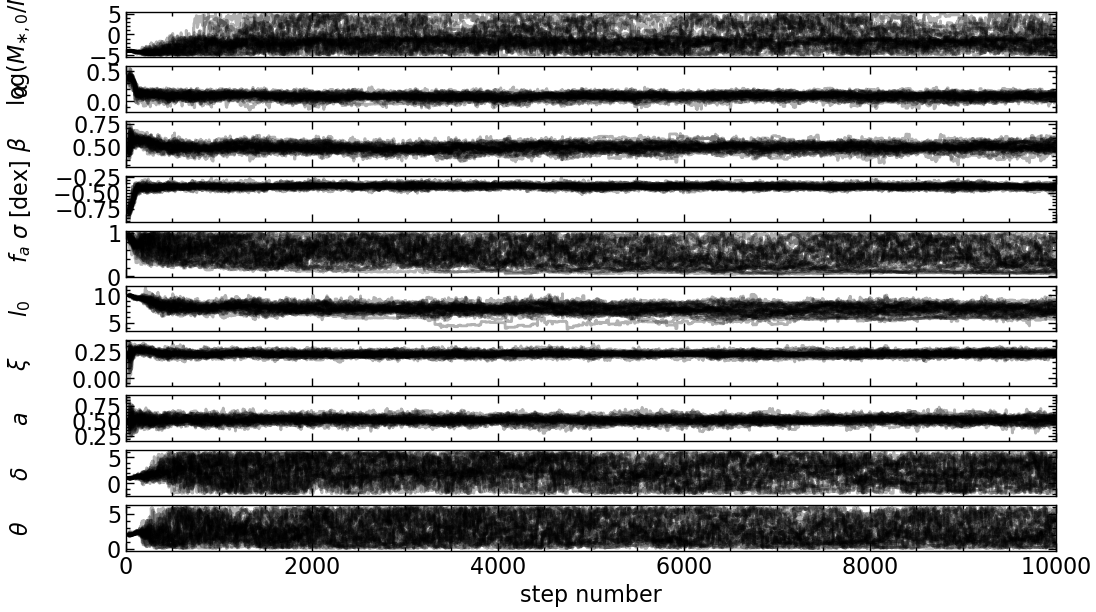

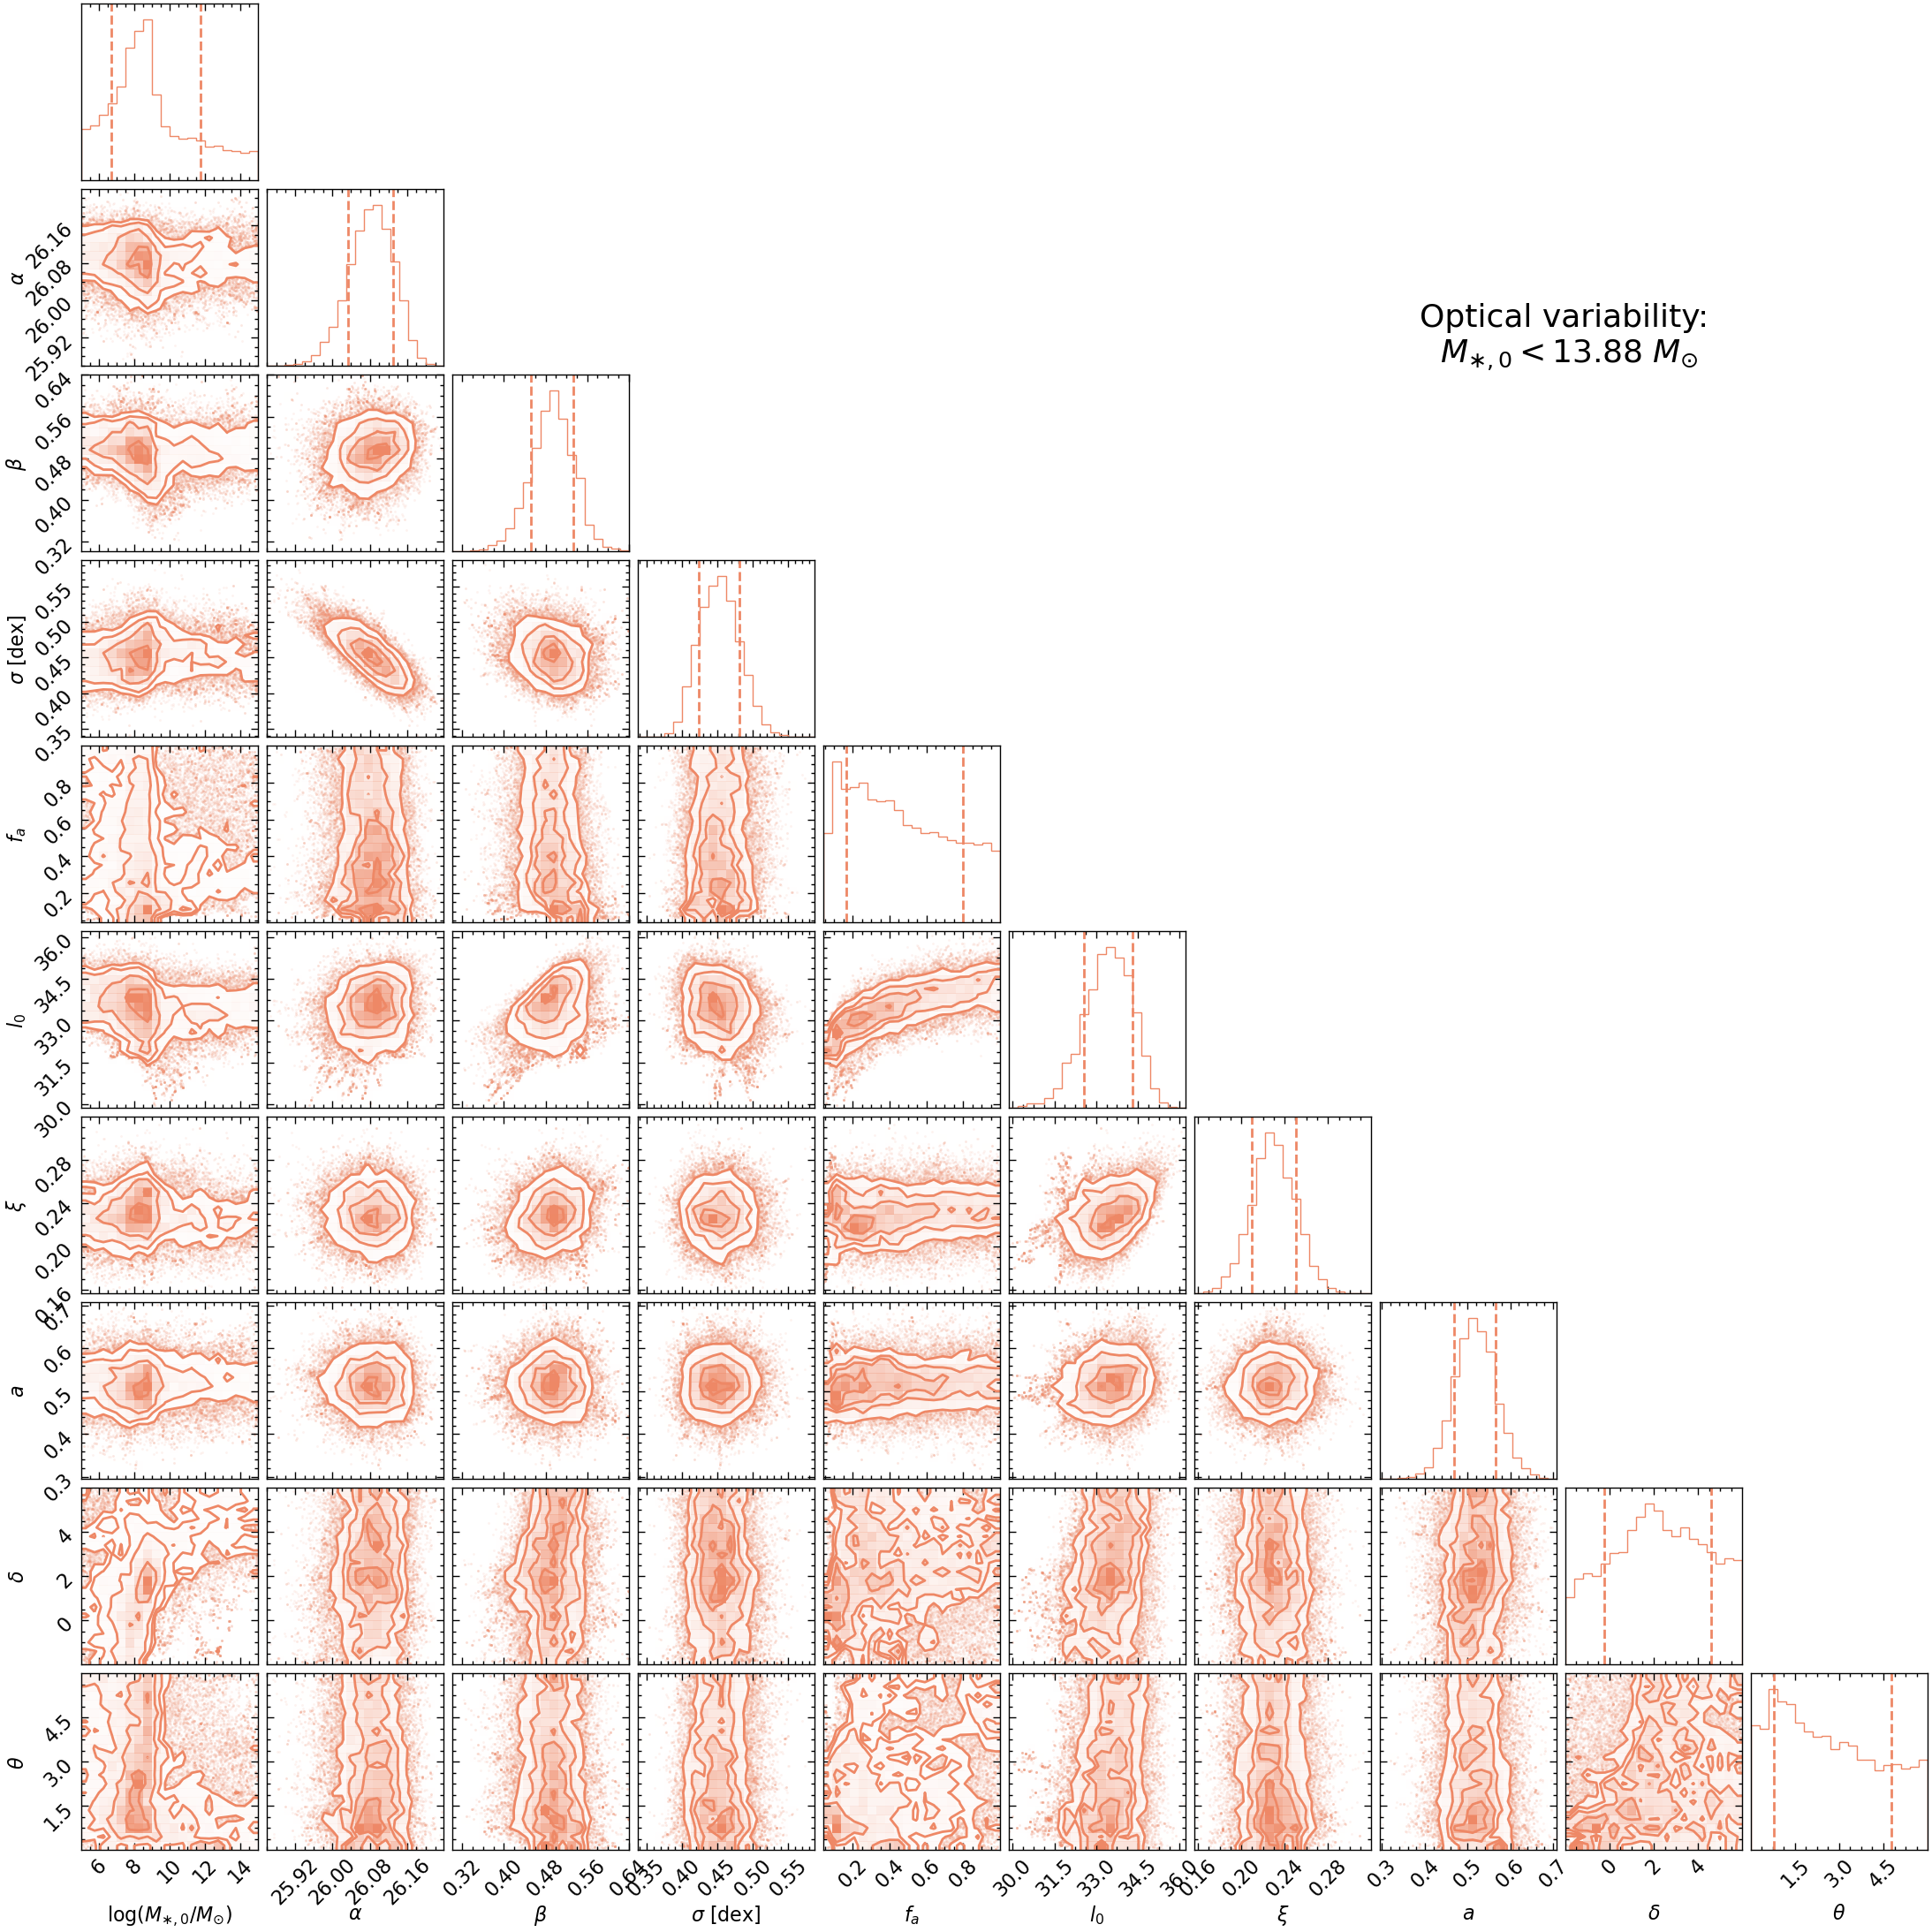

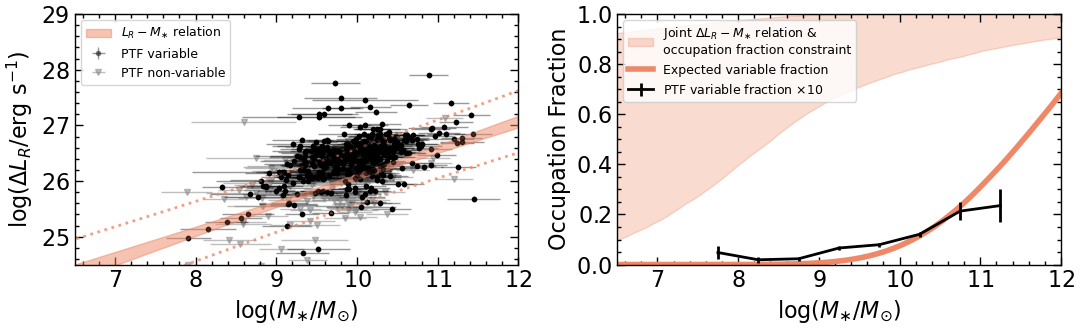

In [175]:
mask_z = np.abs(dat_nsa['z_best'] < 0.055) & (dat_nsa['log_mstar_cigale'] > 0)

data_bgg_z = dat_nsa[mask_z]

mask_det = (data_bgg_z['SigQSO'] > 2) & (data_bgg_z['SigVary'] > 2) & (data_bgg_z['SigQSO'] >= data_bgg_z['SigNotQSO'])

print('detections:', len(data_bgg_z[mask_det]))

#mask_non = (data_bgg['SigVary'] < 2)
mask_non = ~mask_det # This should be correct, even "variable" non-AGN things (SN, etc should count)

data_bgg_det = data_bgg_z[mask_det]
data_bgg_non = data_bgg_z[mask_non]

x = np.concatenate([data_bgg_det['log_mstar_cigale'], data_bgg_non['log_mstar_cigale']])
xerr = np.concatenate([data_bgg_det['log_mstar_err_cigale'], data_bgg_non['log_mstar_err_cigale']])


# 10
m = np.concatenate([data_bgg_det['MedMag'], data_bgg_non['MedMag']])
# Use 2-3* rms as the upper limit
dm = np.concatenate([data_bgg_det['Std'], data_bgg_non['Std']]) # smal dm for non detections helps
z = np.concatenate([data_bgg_det['z'], data_bgg_non['z']])
sigma_var = np.concatenate([data_bgg_det['SigVary'], data_bgg_non['SigVary']])

#TODO: separate into detections and non detections and fix errors, assume ~10 percent error
f = 10**(23 -0.4*(m + 48.6)) # R -> f [Jy]
d_L = cosmo.luminosity_distance(z).to(u.cm).value
L = f*(4*np.pi*d_L**2) * 1e-23 # Lv [erg/s/Hz]

# Convert to dL to make things more intuitive
y = np.log10( np.log(10)/2.5*L*dm ) # dL
#y = -np.log10( np.log(10)/2.5*dm ) # dL

#xerr = np.full_like(y, 0.3) # Change this and things get weird..
yerr = np.concatenate([len(data_bgg_det)*[0.05], len(data_bgg_non)*[-1]])

yerr[yerr==0.0] = 0.434*np.log10(0.1 * np.log(10)/2.5 * L[yerr==0.0]*dm[yerr==0.0]) / y[yerr==0.0]


# TODO: Plot detection fraction inc. only ones that are < 3 sigma away from the relation 
p_obs = np.ones_like(x) #np.clip(np.interp(x, np.log10(M), completeness_BGG), 1e-6, 1)

# Save the input for multiwavelength analysis!
tvar = Table([x, y, xerr, yerr, p_obs], names=['x', 'y', 'xerr', 'yerr', 'pobs'])
tvar.write('tvar.txt', overwrite=True, format='ascii')

## INFERENCE

xp=10.0
yp=26.0

ntest = 1 # 10

nsamp=10000//ntest
nburn=3000//ntest

color='C1'
ylims=[None, None]

x = x-xp
y = y-yp

#np.random.seed(424)
nll = lambda *args: -log_likelihood_init(*args)

initial = np.array([0.0, 0.5, np.log(0.2)])
initial += 1e-4 * np.random.randn(len(initial))
soln = minimize(nll, initial, args=(x, y, xerr, yerr))
alpha_ml, beta_ml, log_f_ml = soln.x

log_f_ml = -0.8

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml+yp))
print("beta = {0:.3f}".format(beta_ml))
print("sigma = {0:.3f}".format(np.exp(2*log_f_ml)))

#      logms0, alpha, beta,    log_f,  f_a, l0, xi, a, delta, theta
pos = [-4, soln.x[0], soln.x[1], -0.8, 0.95, 10, 0.2, 0.5, 1, 2]
pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
nwalkers, ndim = pos.shape

# Sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr, p_obs, xp))

sampler.run_mcmc(pos, nsamp, progress=True);

# Plot
fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()

# logms0, alpha, beta, log_f, f_a, l0, xi, a, s 
labels = [r"$\log(M_{\ast,0}/M_{\odot})$", r"$\alpha$", r"$\beta$", r"$\sigma$ [dex]", r'$f_a$', r'$l_0$', r'$\xi$', r'$a$', r'$\delta$', r'$\theta$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
print(flat_samples.shape)

# Medians
alpha_x50 = np.median(flat_samples[:,1])
beta_x50 = np.median(flat_samples[:,2])
sigma50 = np.median(np.exp(2*flat_samples[:,3]))

# Corner
flat_samples[:,3] = np.exp(2*flat_samples[:,3]) # sigma
#flat_samples[:,4] = np.exp(2*flat_samples[:,4])
flat_samples[:,0] += xp # log M_*,0
flat_samples[:,1] += yp # alpha
flat_samples[:,5] += yp # l0x
fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84], color=color)

# TODO::::: Increase the 1st column limit + 1 and use 95th percentile

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
#inds = np.random.randint(len(flat_samples), size=100)

# Plot data
x_eval = np.linspace(-5, 5, 200)
axes[0].scatter(x[yerr > 0] + xp, y[yerr > 0] + yp, marker='.', color='k')
axes[0].errorbar(x[yerr > 0] + xp, y[yerr > 0] + yp, elinewidth=1,
                    xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                    fmt=".k", capsize=0, alpha=0.4, label='PTF variable')
# Pick random
if len(x[yerr < 0]) > 150:
    ind_rand = np.random.choice(len(x[yerr < 0]), 150, replace=False)
else:
    ind_rand = np.arange(len(x[yerr < 0]))
axes[0].errorbar(x[yerr < 0][ind_rand] + xp, y[yerr < 0][ind_rand] + yp,
                    xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1, label='PTF non-variable')
#axes[0].errorbar(x[(yerr < 0) & (y<40)] + xp, y[(yerr < 0) & (y<40)] + yp,
#                    xerr=xerr[(yerr < 0) & (y<40)], elinewidth=1,
#                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1)
axes[0].legend(fontsize=14)
axes[0].set_xlim([6.5, 12])
axes[0].set_ylim([24.5, 29])
axes[0].set_xlabel(r'$\log(M_{\ast} / M_{\odot})$')
axes[0].set_ylabel(r'$\log(\Delta L_{R} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# Linear relation
relation = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    relation[i,:] = np.dot(np.vander(x_eval, 2), [s[2], s[1]])

axes[0].fill_between(x_eval + xp, np.percentile(relation, 84, axis=0), np.percentile(relation, 16, axis=0),
                        color=color, alpha=0.5, zorder=2, label=r'$L_{R} - M_{\ast}$ relation')
axes[0].plot(x_eval + xp, np.percentile(relation, 84, axis=0)+sigma50,
             color=color, alpha=0.8, zorder=2, linestyle='dotted')
axes[0].plot(x_eval + xp, np.percentile(relation, 16, axis=0)-sigma50,
            color=color, alpha=0.8, zorder=2, linestyle='dotted')

# Limits
log_ms0_low = np.percentile(flat_samples[:,0], 95)
log_ms0_high = np.percentile(flat_samples[:,0], 5)
print('95% CI: ', log_ms0_low)
axes[1].scatter(log_ms0_low, 0.5, color=color)
axes[1].axvline(log_ms0_low, linestyle='dotted', color=color)

# Occupation fraction
alpha50 = np.median(flat_samples[:,1])
beta50 = np.median(flat_samples[:,2])
# Occupation fraction
foccs = np.zeros([len(flat_samples), len(x_eval)])
f1s = np.zeros([len(flat_samples), len(x_eval)])

for i, s in enumerate(flat_samples):
    xii = np.exp(s[8])
    theta2i = s[9]
    foccs[i,:] =  1/(1 + xii * np.exp(-theta2i*(x_eval + xp - s[0])))**(1/xii)
    
    L =  10**(alpha50 + beta50*(x_eval+xp))
    L0 = 10**(s[5])
    f1s[i,:] = 1 - (1 + 3*(L/L0)**(1 - 2*s[6]))**-s[7]

axes[1].fill_between(x_eval + xp, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color=color, alpha=0.3,
                        label=r'Joint $\Delta L_{R} - M_{\ast}$ relation &'+'\n'+'occupation fraction constraint')

# 50% occupation
#axes[1].scatter(log_ms0_low, 0.5, color=color)
#axes[1].axvline(log_ms0_low, linestyle='dotted', color=color, label=r'$50\%$ occupation limit')

y_lim = np.median(y[(yerr<0) & (x+xp>10)]) + yp
fa50 = np.median(flat_samples[:,4])

axes[1].plot(x_eval + xp, 10 * fa50 * np.percentile(f1s, 50, axis=0) * np.percentile(foccs, 16, axis=0) * st.norm.sf(y_lim, alpha50 + beta50*(x_eval), sigma50),
             color=color, lw=4, label=r'Expected variable fraction')

# Histogram
hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(-3, 3, 0.5))
hist_all, bin_edges = np.histogram(x,  bins=np.arange(-3, 3, 0.5))
frac_det = hist_det/hist_all

bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

axes[1].errorbar(bincenter[hist_det>0] + xp, 10*frac_det[hist_det>0],
                    yerr=10*st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                    color="k", capsize=0, label=r'PTF variable fraction $\times  10$')
axes[1].set_xlim([6.5, 12])
axes[1].set_ylim([0, 1])
axes[1].set_xlabel(r"$\log(M_{\ast} / M_{\odot})$")
axes[1].set_ylabel(r"Occupation Fraction")

axes[0].legend(loc=0, fontsize=9, frameon=True)
axes[1].legend(loc=0, fontsize=9, frameon=True)

## IF you see nothing it means init is outside of prior bounds 
# or you have inf/nans in the data / likelihood somewhere

fig_corner.text(.8, .8, 'Optical variability: \n'+r'$M_{\ast,0} < $'+f'{np.round(log_ms0_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)

fig.tight_layout()
fig_corner.savefig('corner_ptf.pdf', dpi=300)
fig.savefig('bhofvar.pdf', dpi=300)

(0.0, 1.0)

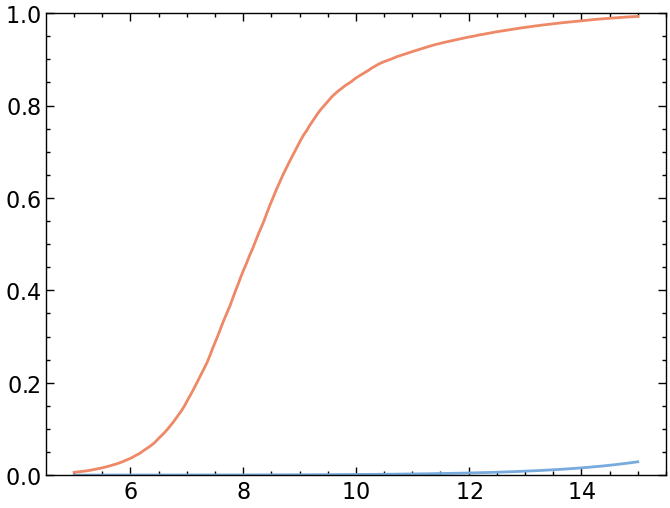

In [172]:
plt.plot(x_eval+xp, 10*np.percentile(f1s, 50, axis=0))
plt.plot(x_eval+xp, np.percentile(foccs, 16, axis=0))
plt.ylim(0, 1)

In [77]:
# grid
dlogm = .1
logms = np.arange(2.0, 16.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

Nsamp = 200

gsmf = np.zeros([len(logms), Nsamp])
bhmf = np.zeros([len(logms), Nsamp])
bhlf = np.zeros([len(logms), Nsamp])

foccs = np.zeros([len(logms), Nsamp])

for i in range(Nsamp):
    # Convolve
    xii = np.exp(flat_samples[i,5])
    theta2i = flat_samples[i,6]
    x50i = flat_samples[i,0]
    foccs[:,i] = 1/(1 + xii * np.exp(-theta2i*(logms - x50i)))**(1/xii)

np.save('focc_ptf', foccs)

In [ ]:
data_bgg_z[(data_bgg_z['log_mstar_cigale'] < 8) & mask_det]

ObjID,RA_1,Dec,Band,Npoints,Baseline,MedMag,Std,SigVary,SigQSO,SigNotQSO,Mstar,BPT,z,nsaid,z_dr16,Mstar_mendel,NSAID,z_gama,z_best,IAUNAME,SUBDIR,RA_2,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,ZLG,ZDIST,ZDIST_ERR,NMGY,NMGY_IVAR,OK,RNMGY,ABSMAG,AMIVAR,EXTINCTION,KCORRECT,KCOEFF,MTOL,B300,B1000,METS,MASS,XCEN,YCEN,NPROF,PROFMEAN,PROFMEAN_IVAR,QSTOKES,USTOKES,BASTOKES,PHISTOKES,PETROFLUX,PETROFLUX_IVAR,FIBERFLUX,FIBERFLUX_IVAR,BA50,PHI50,BA90,PHI90,SERSICFLUX,SERSICFLUX_IVAR,SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY,CLUMPY,DFLAGS,AID,PID,DVERSION,PROFTHETA,PETROTHETA,PETROTH50,PETROTH90,SERSIC_TH50,OBJNO,PLATE,FIBERID,MJD,COEFF,VDISP,D4000,D4000ERR,FA,FAERR,S2FLUX,S2FLUXERR,S2EW,S2EWERR,S2VMEAS,S2VMERR,S2RATIO,HAFLUX,HAFLUXERR,HAEW,HAEWERR,HAVMEAS,HAVMERR,N2FLUX,N2FLUXERR,N2EW,N2EWERR,N2VMEAS,N2VMERR,HBFLUX,HBFLUXERR,HBEW,HBEWERR,HBVMEAS,HBVMERR,O1FLUX,O1FLUXERR,O1EW,O1EWERR,O1VMEAS,O1VMERR,O2FLUX,O2FLUXERR,O2EW,O2EWERR,O2VMEAS,O2VMERR,O3FLUX,O3FLUXERR,O3EW,O3EWERR,O3VMEAS,O3VMERR,AHGEW,AHGEWERR,AHDEW,AHDEWERR,NE3EW,NE3EWERR,NE5EW,NE5EWERR,AV,S2NSAMP,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,log_mstar_cigale,log_mstar_err_cigale
str9,float64,float64,str1,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,float64,float64,bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,float32,float32,float32,float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[7],float32[5],float32[7],float32,float32,float32,float32,float64,float64,float32[7],"float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]",float32[7],float32[7],float32[7],float32[7],float32,float32,float32,float32,float32[7],float32[7],float32,float32,float32,float32[7],float32[7],int32[7],int32,int32,bytes8,float32[15],float32,float32,float32,float32,int32,int32,int32,int32,float32[7],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,bytes6,bytes23,bytes8,int32,float64,float64,float64,float64
NSA57867,244.760364,29.17284096,r,139,1953.97495,18.46475658,0.04339128798,8.125891,7.393309,0.001584,48888261.2244898,1,0.00845791213214397,57867,0.00846,-1.0,57867,-1.0,0.00846,J161902.54+291022.2,16h/p28/J161902.54+291022.2,244.76036400229154,29.172840957954286,59030,178377,-1,-1,128568,-1,17.45021,0.008457912,sdss,0.07,3723,4,142,301,822.06335,455.60367,0.008768324,0.008545843,0.00041695577,25.888512 .. 142.88173,0.63666755 .. 0.030253196,1,24.429258 .. 141.70508,-13.082755 .. -14.939158,361.97467 .. 523.93335,0.31924593 .. 0.05695594,-0.0071493764 .. -0.0054199845,1.6988537e-10 .. 1.2763969e-06,4.2953225e-06 .. 0.40135038,0.11690408,0.26742002,0.017624704,23955248.0,90.3927001953125,90.54930877685547,0.92501056 .. 1.0694703,0.92501056 .. 0.0,153.82925 .. 0.0,0.0065613454 .. -0.2773382,0.0014223808 .. 0.07091744,0.98666203 .. 0.55489355,6.1157136 .. 82.8282,13.86959 .. 152.1195,5.5857396 .. 0.009358429,2.304005 .. 33.820705,40.472614 .. 0.5156582,0.8440993,146.02698,0.7797527,149.18628,19.293396 .. 140.66768,2.7239058 .. 0.05906414,1.0987589,0.726498,147.85425,0.1881705 .. -0.023779213,0.32659864 .. -0.16109723,0 .. 0,0,57,v2_1_5,0.22341923 .. 258.39,5.7860413,2.6852586,6.9848614,2.8281002,140749486,1407,494,52886,0.018812379 .. 5.3e-44,75.09476,1.0826703,0.02124429,0.4720691,0.047420107,132.34135,4.3523273,14.686541,0.81953156,42.839783,2.1981902,0.6829113,675.9179,6.8019657,

In [ ]:
# Stellar mass of some sources look quite wrong
# https://skyserver.sdss.org/dr18/VisualTools/explore/summary?ra=126.8497276&dec=23.18012299

### Galaxy stellar mass function